# Homework 3 (Convolutional Neural Networks)

[Fruit and Veg Detection Data](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from keras.datasets import mnist
import keras as kb
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.preprocessing import LabelBinarizer

from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [2]:
!mkdir ~/.kaggle

# move kaggle.json to hidden kaggle folder
!cp kaggle.json ~/.kaggle/

# change permissions on file
!chmod 600 ~/.kaggle/kaggle.json

# download zipped data
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

100% 1.98G/1.98G [01:07<00:00, 29.4MB/s]
100% 1.98G/1.98G [01:07<00:00, 31.4MB/s]


In [3]:
!unzip -qq /content/fruit-and-vegetable-image-recognition.zip

In [4]:
train_dir = '/content/train'
test_dir = '/content/test'
val_dir = '/content/validation'

In [6]:
batch_size = 32
image_width = 256
image_height = 256


train_ds = kb.utils.image_dataset_from_directory(
  train_dir, # file path
  seed=123, # seed
  image_size= (image_width, image_height), # size of image
  batch_size=batch_size, # number of images per batch
  label_mode='categorical', # one-hot-encoding
  shuffle = True)

val_split = 0.2  # Use 20% of the training data for validation!
train_ds = kb.utils.image_dataset_from_directory(
  train_dir,
  validation_split=val_split,
  subset="training",
  seed=123,
  image_size=(image_width, image_height),
  batch_size=batch_size,
  label_mode='categorical')

val_ds = kb.utils.image_dataset_from_directory(
  train_dir,
  validation_split=val_split,
  subset="validation",
  seed=123,
  image_size=(image_width, image_height),
  batch_size=batch_size,
  label_mode='categorical')

test_ds = kb.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_width, image_height),
  batch_size=batch_size,
  label_mode='categorical')

Found 3115 files belonging to 36 classes.
Found 3115 files belonging to 36 classes.
Using 2492 files for training.
Found 3115 files belonging to 36 classes.
Using 623 files for validation.
Found 359 files belonging to 36 classes.


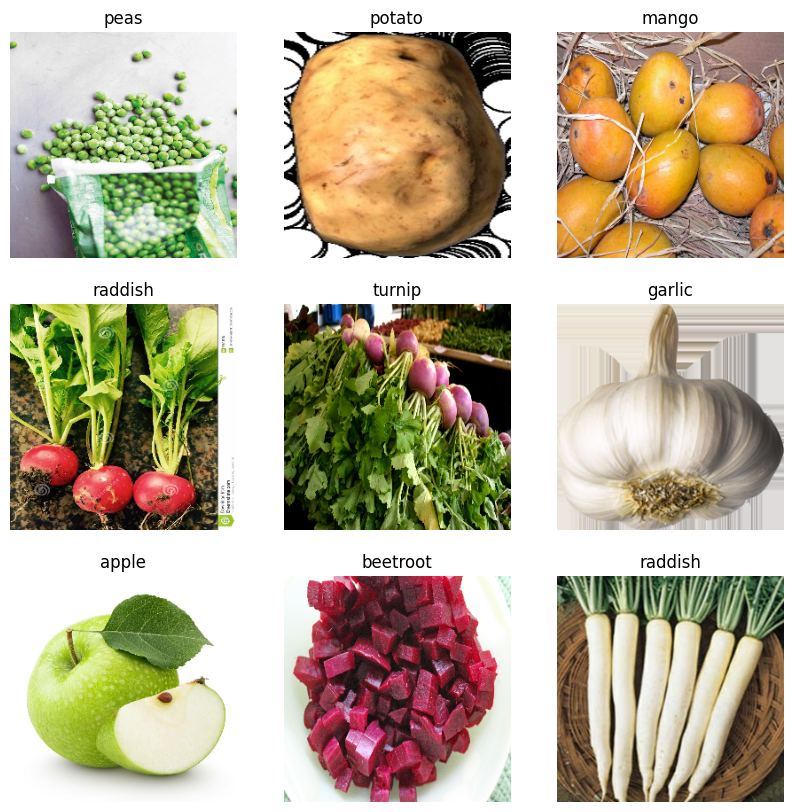

In [7]:
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take a single batch
        for i in range(9):  # Display the first 9 images from the batch
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")

class_names = train_ds.class_names

show_images(train_ds, class_names)

In [ ]:
# From chatGPT

def count_classes(dataset):
    # Assuming your dataset yields tuples of (images, one-hot encoded labels)
    # and that your dataset is batched.
    class_counts = None
    for images, labels in dataset:
        # Sum up the one-hot encoded labels
        sum_labels = np.sum(labels, axis=0)
        if class_counts is None:
            class_counts = sum_labels
        else:
            class_counts += sum_labels
    return class_counts

# Count classes in the training dataset
train_class_counts = count_classes(train_ds)

# Assuming `class_names` is a list of class names in the same order as the one-hot encoding
for class_name, count in zip(class_names, train_class_counts):
    print(f"{class_name}: {count}")

# This will print out the count of each class in your training dataset


apple: 53.0
banana: 58.0
beetroot: 75.0
bell pepper: 73.0
cabbage: 69.0
capsicum: 70.0
carrot: 65.0
cauliflower: 65.0
chilli pepper: 73.0
corn: 70.0
cucumber: 68.0
eggplant: 72.0
garlic: 79.0
ginger: 49.0
grapes: 82.0
jalepeno: 73.0
kiwi: 66.0
lemon: 65.0
lettuce: 78.0
mango: 70.0
onion: 74.0
orange: 59.0
paprika: 70.0
pear: 63.0
peas: 88.0
pineapple: 80.0
pomegranate: 67.0
potato: 63.0
raddish: 60.0
soy beans: 69.0
spinach: 72.0
sweetcorn: 74.0
sweetpotato: 56.0
tomato: 77.0
turnip: 81.0
watermelon: 66.0


# Question 1 - CNN, Image Classification

In [ ]:
# DEEP CNN MODEL

input_size=(256,256,3)

# Layer 1
input = kb.layers.Input(shape = input_size)
conv1 = kb.layers.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(input)
pool1 = kb.layers.MaxPool2D((4,4))(conv1)
norm1 = kb.layers.BatchNormalization(axis = -1)(pool1)
drop1 = kb.layers.Dropout(0.2)(norm1)

# Layer 2
conv2 = kb.layers.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(drop1)
pool2 = kb.layers.MaxPool2D((4,4))(conv2)
norm2 = kb.layers.BatchNormalization(axis = -1)(pool2)
drop2 = kb.layers.Dropout(0.2)(norm2)

# Layer 3
conv3 = kb.layers.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same", kernel_regularizer = 'l2')(drop2)
pool3 = kb.layers.MaxPool2D((4,4))(conv3)
norm3 = kb.layers.BatchNormalization(axis = -1)(pool3)
drop3 = kb.layers.Dropout(0.2)(norm3)

# Layer 4
conv4 = kb.layers.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(drop3)
pool4 = kb.layers.MaxPool2D((2,2))(conv4)
norm4 = kb.layers.BatchNormalization(axis = -1)(pool4)
drop4 = kb.layers.Dropout(0.2)(norm4)

# Layer 5
conv5 = kb.layers.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same")(drop4)
pool5 = kb.layers.MaxPool2D((2,2))(conv5)
norm5 = kb.layers.BatchNormalization(axis = -1)(pool5)
drop5 = kb.layers.Dropout(0.2)(norm5)


flat = kb.layers.Flatten()(drop5)

hidden1 = kb.layers.Dense(256,activation="relu")(flat)
norm3 = kb.layers.BatchNormalization(axis=-1)(hidden1)
drop3 = kb.layers.Dropout(rate=0.2)(norm3)

hidden2 = kb.layers.Dense(128,activation="relu")(drop3)
norm4 = kb.layers.BatchNormalization(axis=-1)(hidden2)
drop4 = kb.layers.Dropout(rate=0.2)(norm4)

output = kb.layers.Dense(36,activation="softmax")(drop4)

model = kb.Model(inputs = input , outputs = output)

model.compile(optimizer=kb.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

callbacks = [
  EarlyStopping(monitor='val_categorical_accuracy', patience=20, verbose=1, mode = 'max', restore_best_weights=True),
  ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', mode = 'max', save_best_only=True, verbose=1),
  # LearningRateScheduler(scheduler)
]

history = model.fit(
    train_ds,
    epochs=500,
    validation_data= val_ds,
    callbacks = callbacks
)

In [66]:
# Predict the test dataset
test_images, test_labels_one_hot = next(iter(test_ds.unbatch().batch(len(test_ds))))
test_preds_one_hot = model.predict(test_images)

train_images, train_labels_one_hot = next(iter(train_ds.unbatch().batch(len(train_ds))))
train_preds_one_hot = model.predict(train_images)

# Convert one-hot encoded predictions and labels to class indices
test_preds = np.argmax(test_preds_one_hot, axis=1)
test_labels = np.argmax(test_labels_one_hot, axis=1)

train_preds = np.argmax(train_preds_one_hot, axis=1)
train_labels = np.argmax(train_labels_one_hot, axis=1)

# Calculate accuracy and F1 score
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

accuracy = accuracy_score(train_labels, train_preds)
f1 = f1_score(train_labels, train_preds, average='weighted')

print(f'Train Accuracy: {accuracy*100:.4f}%')
print(f'Train F1 Score: {f1*100:.4f}%')

print(f'Test Accuracy: {test_accuracy*100:.4f}%')
print(f'Test F1 Score: {test_f1*100:.4f}%')

3/3 [==============================] - 0s 9ms/step
Train Accuracy: 84.6154%
Train F1 Score: 83.6661%
Test Accuracy: 91.6667%
Test F1 Score: 94.4444%


In [ ]:
# Used chat GPT here :)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Question 2 - Transfer learning approach, Image Classification

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load VGG16 model, pre-trained on ImageNet
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_width, image_height, 3)
)

# Freeze the convolutional base
for layer in base_model.layers[:15]:
    layer.trainable = False

# Create a new model that starts with the VGG16 base
inputs = keras.Input(shape=(image_width, image_height, 3))
# Note: Ensure you apply the same preprocessing as VGG16's requirement
x = keras.applications.vgg16.preprocess_input(inputs)

# Add the VGG16 base model as the initial layers
x = base_model(x, training=False)

# Now add your "head" layers on top
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization(axis=-1)(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(36, activation='softmax')(x)

# Construct the final model
transfer_model = keras.Model(inputs, output)

# Compile the model
transfer_model.compile(loss="categorical_crossentropy",
                       optimizer=keras.optimizers.Adam(),
                       metrics=["categorical_accuracy"])

# Now you can fit your model as before
history_vgg = transfer_model.fit(
    train_ds,
    epochs=500,
    validation_data=val_ds,
    callbacks=callbacks
)


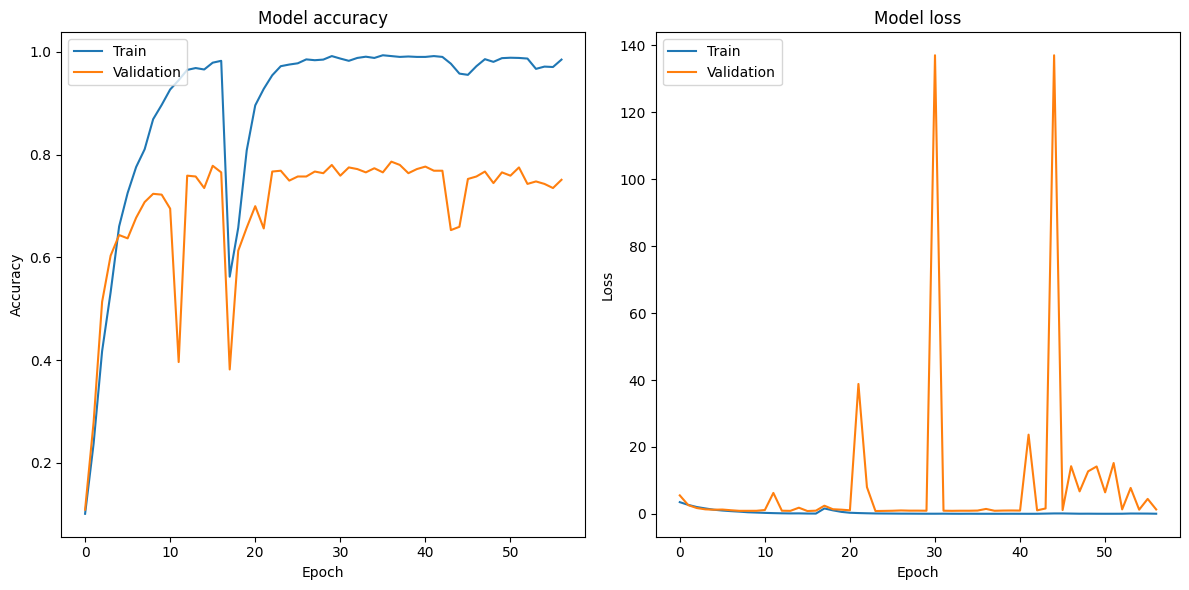

In [60]:
# Used chat GPT here :)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['categorical_accuracy'])
plt.plot(history_vgg.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [62]:
# Predict the test dataset
test_images, test_labels_one_hot = next(iter(test_ds.unbatch().batch(len(test_ds))))
test_preds_one_hot = model.predict(test_images)

train_images, train_labels_one_hot = next(iter(train_ds.unbatch().batch(len(train_ds))))
train_preds_one_hot = model.predict(train_images)

# Convert one-hot encoded predictions and labels to class indices
test_preds = np.argmax(test_preds_one_hot, axis=1)
test_labels = np.argmax(test_labels_one_hot, axis=1)

train_preds = np.argmax(train_preds_one_hot, axis=1)
train_labels = np.argmax(train_labels_one_hot, axis=1)

# Calculate accuracy and F1 score
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

accuracy = accuracy_score(train_labels, train_preds)
f1 = f1_score(train_labels, train_preds, average='weighted')

print(f'Train Accuracy: {accuracy*100:.4f}%')
print(f'Train F1 Score: {f1*100:.4f}%')

print(f'Test Accuracy: {test_accuracy*100:.4f}%')
print(f'Test F1 Score: {test_f1*100:.4f}%')

3/3 [==============================] - 0s 71ms/step
Train Accuracy: 83.3333%
Train F1 Score: 81.8440%
Test Accuracy: 75.0000%
Test F1 Score: 80.5556%


In [64]:
transfer_model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 256, 256, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               419

In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a Gradcam object
    gradcam = Gradcam(model, model_modifier=None, clone=True)

    # Define loss function. If pred_index is specified, use it; otherwise, use the predicted class.
    def loss(output):
        if pred_index is None:
            return tf.reduce_max(output, axis=1)
        return output[:, pred_index]

    # Generate heatmap with GradCAM
    heatmap = gradcam(loss, img_array, penultimate_layer=-1)
    heatmap = normalize(heatmap)

    return heatmap[0]

def overlay_heatmap_on_image(image, heatmap, alpha=0.5):
    """
    Overlays the heatmap on the original image.
    Args:
    - image: The original image.
    - heatmap: The heatmap to overlay.
    - alpha: Transparency factor of the heatmap.
    """
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Resize the heatmap to match the original image
    jet_heatmap = tf.image.resize(jet_heatmap, (image.shape[0], image.shape[1]))
    # Overlay the heatmap on original image
    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 1.0)
    return superimposed_img

  # Assuming `val_ds` is your dataset
for images, _ in val_ds.take(1):
    img_array = images[0:1]  # Taking a single image from the batch
    break

# Ensure image is preprocessed if not already done
img_array_processed = tf.keras.applications.vgg16.preprocess_input(img_array)

# Specify the name of the last convolutional layer you want to visualize
last_conv_layer_name = 'block5_conv3'

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array_processed, transfer_model, last_conv_layer_name)

# Convert the processed image array back to display format if necessary
image_display = np.array(img_array[0])

# Assuming the image is normalized in [0, 1], if not, you might need to adjust it
image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

# Overlay the heatmap
superimposed_img = overlay_heatmap_on_image(image_display, heatmap)

# Display the original image with heatmap overlay
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") at layer "block1_conv1". The following previous layers were accessed without issue: []

Self-made Model Predictions
1/1 [==============================] - 0s 22ms/step


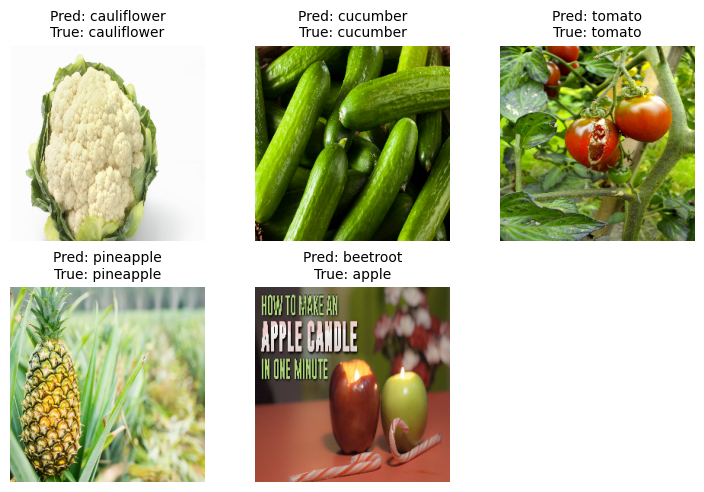


Transfer Learning Model Predictions
1/1 [==============================] - 0s 22ms/step


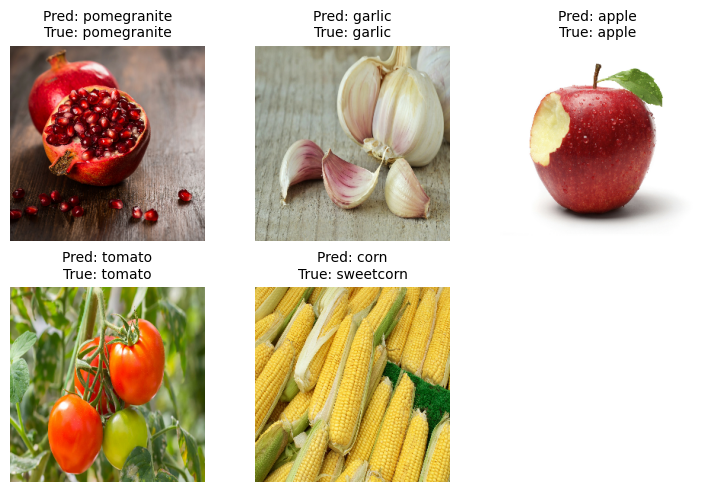

In [71]:
# From ChatGPT :)

def plot_images_with_predictions(dataset, model, class_names, num_images=6, cols=3):
    # Calculate the number of rows needed to display the images in the specified number of columns
    rows = num_images // cols + int(num_images % cols > 0)

    plt.figure(figsize=(2.5 * cols, 2.5 * rows))

    images, labels = next(iter(dataset.unbatch().batch(num_images)))  # Get exactly num_images to display
    predictions = model.predict(images)

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Convert labels from one-hot encoding if necessary
        if labels[i].numpy().ndim > 0:
            true_index = np.argmax(labels[i].numpy())
        else:
            true_index = labels[i].numpy()

        predicted_index = np.argmax(predictions[i])

        # Determine class names
        true_label = class_names[true_index]
        predicted_label = class_names[predicted_index]

        # Set title with predicted and true labels
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# array of class names ordered according to how they were encoded
class_names = ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capscium', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber',
               'eggplant', 'garlic', 'ginger', 'grapes', 'jalapeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange','paprika',
               'pear', 'peas', 'pineapple', 'pomegranite', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweet potato',
               'tomato', 'turnip', 'watermelon']

# Unbatch the test dataset and batch it with 1 to get one image per batch for prediction
test_ds_unbatched = test_ds.unbatch().batch(1)

#model
print("Self-made Model Predictions")
plot_images_with_predictions(test_ds_unbatched, model, class_names, num_images=5)

print()
print("Transfer Learning Model Predictions")
# Transfer model
plot_images_with_predictions(test_ds_unbatched, transfer_model, class_names, num_images=5)
